In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)

# Define your custom palette as a list of hex codes
custom_palette = ['#FA6559', '#63C5DA','#343434']

# Set the palette to the custom palette
sns.set_palette(custom_palette)

# Now, all your Seaborn plots will use the colors from the custom palette you defined
sns.set_style("white")

In [2]:
#Reading up the dataframes
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [77]:
df = pd.read_csv("/content/drive/MyDrive/m5-forecasting-uncertainty/train_texas.csv")
test = pd.read_csv("/content/drive/MyDrive/m5-forecasting-uncertainty/test_texas.csv")

In [68]:
print(len(test))
print(len(df))

213430
1560823


In [72]:
df['count_holidays'].unique()

array([ 2., nan,  1.,  3.])

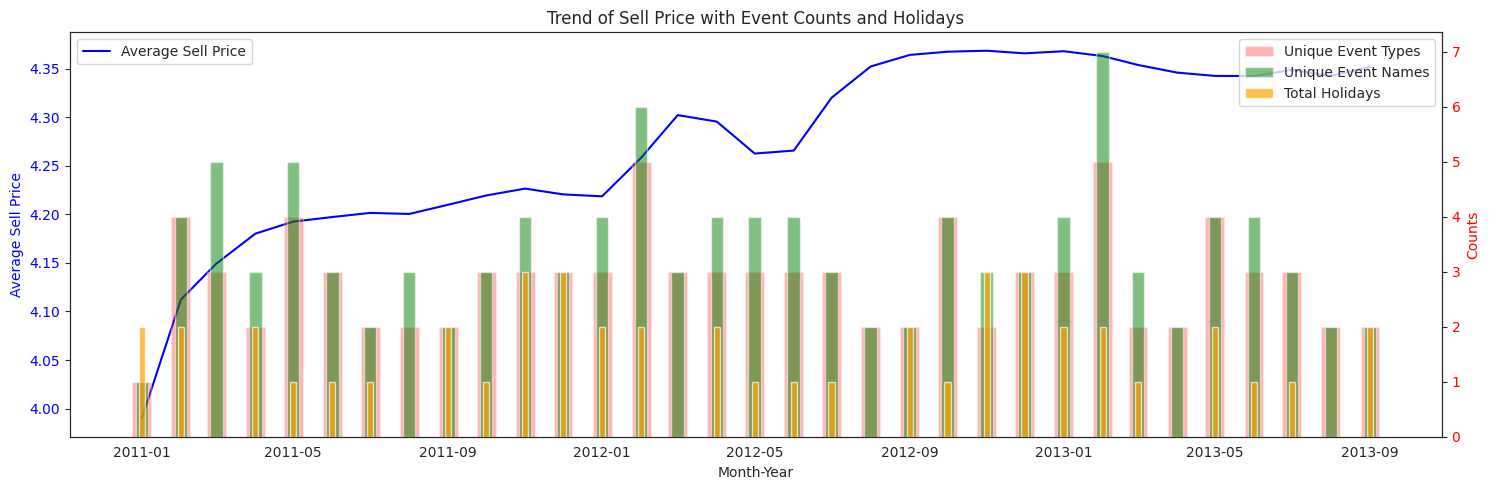

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' has 'month', 'year', 'event_name_1', 'event_type_1', and 'count_holidays' columns

# First, create a column that combines year and month for sorting
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Sort the DataFrame by 'year_month'
df.sort_values(by='year_month', inplace=True)

# Group by 'year_month' and calculate the metrics
monthly_data = df.groupby(['year_month',]).agg(
    average_sell_price=pd.NamedAgg(column='sell_price', aggfunc='mean'),
    unique_event_types=pd.NamedAgg(column='event_type_1', aggfunc=pd.Series.nunique),
    unique_event_names=pd.NamedAgg(column='event_name_1', aggfunc=pd.Series.nunique),
    total_holidays=pd.NamedAgg(column='count_holidays', aggfunc='mean')
).reset_index()

# Convert 'year_month' to a datetime to ensure correct plotting
monthly_data['year_month'] = pd.to_datetime(monthly_data['year_month'])

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 5))

# Line plot for average sell price
sns.lineplot(data=monthly_data, x='year_month', y='average_sell_price', ax=ax1, label='Average Sell Price', color='blue')
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Average Sell Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the unique counts and sum of holidays
ax2 = ax1.twinx()

# Bar plot for unique event types, event names, and sum of holidays
ax2.bar(monthly_data['year_month'], monthly_data['unique_event_types'], width=15, label='Unique Event Types', alpha=0.3, color='red')
ax2.bar(monthly_data['year_month'], monthly_data['unique_event_names'], width=10, label='Unique Event Names', alpha=0.5, color='green')
ax2.bar(monthly_data['year_month'], monthly_data['total_holidays'], width=5, label='Total Holidays', alpha=0.7, color='orange')
ax2.set_ylabel('Counts', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.title('Trend of Sell Price with Event Counts and Holidays')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Model

In [78]:
df.columns

Index(['Unnamed: 0', 'id', 'event_name_1', 'event_type_1', 'snap_TX', 'month',
       'year', 'sales', 'sell_price', 'count_holidays', 'CPI'],
      dtype='object')

In [60]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and it contains both training and test sets
df.drop(columns=['Unnamed: 0','id','month', 'year', 'sales', 'CPI'],axis=1,inplace=True)
# Identify categorical and continuous columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
continuous_columns = df.select_dtypes(include=[np.number]).columns.drop('sell_price')

# Fill in null values and encode categorical columns
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')  # Or any other placeholder
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# Fill in null values for continuous columns and scale
scaler = MinMaxScaler(feature_range=(0, 1))
for col in continuous_columns:
    df[col] = df[col].fillna(df[col].mean())
    df[col] = scaler.fit_transform(df[[col]])

#-----------------------------------------------------------------------------------------------------------
# Assuming test is your DataFrame and it contains both training and test sets
test.drop(columns=['Unnamed: 0','id','month', 'year', 'sales','CPI'],axis=1,inplace=True)
# Identify categorical and continuous columns
categorical_columns = test.select_dtypes(include=['object', 'category']).columns
continuous_columns = test.select_dtypes(include=[np.number]).columns.drop('sell_price')

# Fill in null values and encode categorical columns
for col in categorical_columns:
    test[col] = test[col].fillna('Unknown')  # Or any other placeholder
    encoder = LabelEncoder()
    test[col] = encoder.fit_transform(test[col])

# Fill in null values for continuous columns and scale
scaler = MinMaxScaler(feature_range=(0, 1))
for col in continuous_columns:
    test[col] = test[col].fillna(test[col].mean())
    test[col] = scaler.fit_transform(test[[col]])

#-----------------------------------------------------------------------------------------------------------
# Separate features and labels
X_train = df.drop(columns=['sell_price'])
y_train = df['sell_price']

X_test = test.drop(columns=['sell_price'])
y_test = test['sell_price']


# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters for the model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1  # This is to control the verbosity of the output
}

# Train the model
evals_result = {}  # To store evaluation results
gbm_model = lgb.train(params,
                      train_data,
                      valid_sets=[valid_data],
                      num_boost_round=1000)  # Early stopping

# Prediction
y_pred = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)

In [61]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true, y_pred = y_true[y_true != 0], y_pred[y_true != 0]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}%')


MAPE: 96.96178217224882%


In [62]:
# Print feature importance
importance = gbm_model.feature_importance(importance_type='gain')
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values('Importance', ascending=False)
print(feature_importance_df)

          Feature   Importance
0    event_name_1  7456.411274
3  count_holidays  3903.221445
2         snap_TX  2745.595858
1    event_type_1  2113.295206


In [63]:
# Define the importance scores for each feature
feature_importance_df

# Calculate the total importance score
total_importance = sum(feature_importance_df['Importance'])

# Normalize the importance scores (so they sum to 1)
feature_importance_df['normalized_importance_percentage']=(feature_importance_df['Importance']/total_importance)*100
feature_importance_df

Feature   Importance  normalized_importance_percentage
0    event_name_1  7456.411274                         45.974661
3  count_holidays  3903.221445                         24.066441
2         snap_TX  2745.595858                         16.928765
1    event_type_1  2113.295206                         13.030133